# Importar librerías

In [137]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Importar base de datos

In [138]:
df = pd.read_csv('Datasets/datos_limpios.csv')
df.job_level = df.job_level.astype(str)
df.stock_option_level = df.stock_option_level.astype(str)
df.training_times_last_year = df.training_times_last_year.astype(str)
df = df.drop(['employee_id'], axis=1)

In [139]:
df.shape

(4401, 26)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         4401 non-null   int64  
 1   attrition                   4401 non-null   object 
 2   business_travel             4401 non-null   object 
 3   department                  4401 non-null   object 
 4   distance_from_home          4401 non-null   int64  
 5   education                   4401 non-null   object 
 6   education_field             4401 non-null   object 
 7   gender                      4401 non-null   object 
 8   job_level                   4401 non-null   object 
 9   job_role                    4401 non-null   object 
 10  marital_status              4401 non-null   object 
 11  monthly_income              4401 non-null   int64  
 12  num_companies_worked        4401 non-null   float64
 13  percent_salary_hike         4401 

# Análisis de correlación

## Correlación de variables numéricas

Seleccionar variables numéricas

In [141]:
df_numericas = df.select_dtypes(include=['int64', 'float64'])

Obtener matriz de correlaciones

In [142]:
corr_matrix = df_numericas.corr()
corr_matrix = corr_matrix.apply(lambda x: np.round(x, 2))
corr_matrix

,age,distance_from_home,monthly_income,num_companies_worked,percent_salary_hike,total_working_years,years_at_company,years_since_last_promotion,years_with_curr_manager,mean_time
age,1.00,0.01,-0.04,0.30,-0.03,0.68,0.31,0.22,0.20,-0.00
distance_from_home,0.01,1.00,-0.02,-0.01,0.04,0.01,0.03,0.00,0.02,0.01
monthly_income,-0.04,-0.02,1.00,-0.02,0.00,-0.03,0.00,0.06,0.02,-0.01
num_companies_worked,0.30,-0.01,-0.02,1.00,0.03,0.24,-0.12,-0.04,-0.11,-0.02
percent_salary_hike,-0.03,0.04,0.00,0.03,1.00,-0.02,-0.03,-0.03,-0.04,0.03
total_working_years,0.68,0.01,-0.03,0.24,-0.02,1.00,0.63,0.40,0.46,-0.01
years_at_company,0.31,0.03,0.00,-0.12,-0.03,0.63,1.00,0.62,0.77,-0.02
years_since_last_promotion,0.22,0.00,0.06,-0.04,-0.03,0.40,0.62,1.00,0.51,-0.01
years_with_curr_manager,0.20,0.02,0.02,-0.11,-0.04,0.46,0.77,0.51,1.00,-0.03
mean_time,-0.00,0.01,-0.01,-0.02,0.03,-0.01,-0.02,-0.01,-0.03,1.00


Mapa de calor de correlaciones

In [143]:
fig = px.imshow(corr_matrix, text_auto=True)
fig.layout.update(height=500)
fig.show()

Las correlaciones más significativas son:

- Entre edad y total de años trabajando. Con una correlación de 0.68, tiene sentido que los empleados de más edad sean los que lleven más años trabajando.

- Entre total de años trabajando y total de años en la compañía. Los empleados que llevan más años como empleados tienden a ser los que llevan más años en la compañía.

- Entre años en la compañía y años desde la última promoción. Entre más tiempo tenga el empleado en la compañía es más probable que haya pasado mucho tiempo desde su último ascenso.

- Entre años en la compañía y años al mando del jefe actual.

Todas las variables relacionadas con el tiempo de estancia del empleado en la empresa tienen una correlación alta. 'years_at_company' y 'years_with_curr_manager' se pueden considerar variables redundantes y sería bueno eliminar una de estas, veremos qué resultados obtenemos con otros métodos de selección de variables como la regularización.

## Correlación entre la variable objetivo y variables categóricas

Obtener variables categóricas

In [144]:
df_categoricas = df.select_dtypes(include='object')
df_categoricas.columns

Index(['attrition', 'business_travel', 'department', 'education',
       'education_field', 'gender', 'job_level', 'job_role', 'marital_status',
       'stock_option_level', 'training_times_last_year',
       'environment_satisfaction', 'job_satisfaction', 'work_life_balance',
       'job_involvement', 'performance_rating'],
      dtype='object')

Función que calcula los p-valores de la prueba chi cuadrado entre la variable objetivo y cada variable categórica independiente.

In [145]:
from scipy.stats import chi2_contingency

def corr_car(df):
    
    cols = df.columns
    df_corr_cat = pd.DataFrame()

    corrs = []
    for col in cols:
        tabla_contingencia = pd.crosstab(df['attrition'], df[col])
        chi2, p, _, _ = chi2_contingency(tabla_contingencia)
        corrs.append(p)
    df_corr_cat['attrition'] = corrs
    df_corr_cat.index = cols
    
    return df_corr_cat

In [146]:
df_corr_cat = corr_car(df_categoricas)
df_corr_cat

,attrition
attrition,0.000000e+00
business_travel,2.702521e-16
department,1.076723e-06
education,2.158986e-01
education_field,8.191044e-09
gender,2.347675e-01
job_level,1.889185e-01
job_role,2.365690e-03
marital_status,1.547837e-30
stock_option_level,3.377544e-01


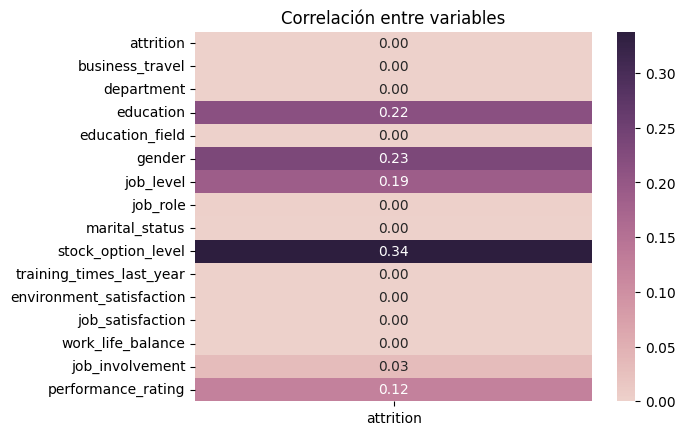

In [147]:
plt.figure()
sns.heatmap(df_corr_cat, annot = True, cmap = sns.cubehelix_palette(as_cmap=True), fmt = ".2f")
plt.title("Correlación entre variables")
plt.show()

Utilizando un nivel de significancia de 0.05, se puede concluir de las pruebas chi cuadrado que no hay evidencias de que las variables Educación, Género, Nivel del puesto, Nivel de opciones sobre acciones del empleado y Valoración del rendimiento en el último año tienen una correlación significativa con la variable objetivo(el empleado abandonó el año anterior).

## Correlación entre la variable objetivo y las variables numéricas independientes

In [158]:
fig = make_subplots(
    rows=4, cols=3,
    specs=[[{"type": "box"}, {"type": "box"}, {"type": "box"}],
           [{"type": "box"}, {"type": "box"}, {"type": "box"}],
           [{"type": "box"}, {"type": "box"}, {"type": "box"}],
           [{"type": "box"}, {"type": "box"}, {"type": "box"}]]
)
    
rows = [1,1,1,2,2,2,3,3,3,4,4,4]
cols = [1,2,3,1,2,3,1,2,3,1,2,3]

for i in range(len(df_numericas.columns)):
    
    fig.add_trace(go.Box(x=df["attrition"], y = df_numericas.iloc[:,i], name=df_numericas.columns[i]),
                  row=rows[i], col=cols[i])
    
fig.update_layout(height=900, showlegend=True)
fig.show()

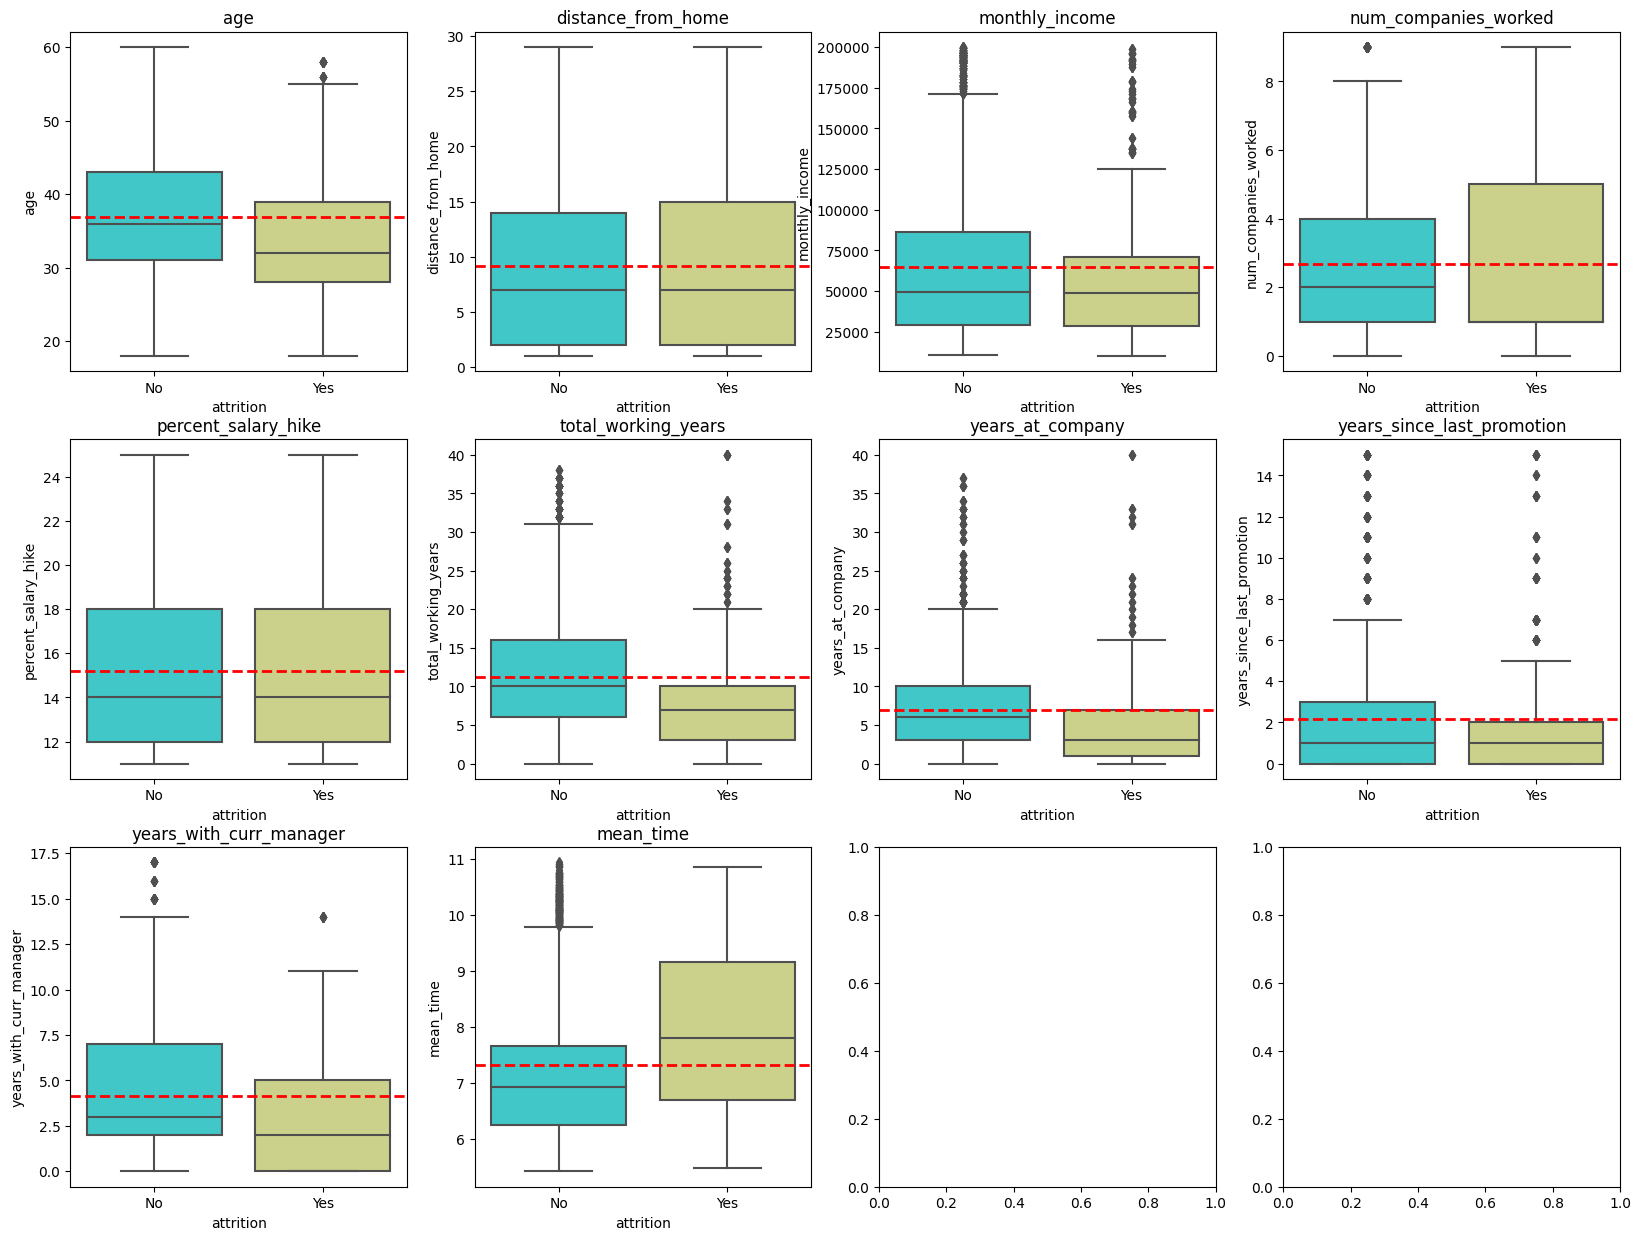

In [165]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

rows = [0,0,0,0,1,1,1,1,2,2,2,2,]
cols = [0,1,2,3,0,1,2,3,0,1,2,3]
variables = df_numericas.columns

for i in range(len(variables)):

    sns.boxplot(x = 'attrition', y = variables[i], data = df, palette='rainbow', ax=axs[rows[i], cols[i]])
    axs[rows[i], cols[i]].set_title(variables[i])
    axs[rows[i], cols[i]].axhline(df[variables[i]].mean(), color='r',linestyle='dashed',linewidth=2)

In [150]:
df_numericas.iloc[:,1].mean()

9.190184049079754